<center> </center>

<center><font size=5 face="Helvetica" color=#306998><b>
Meep Tutorial: Transmission and Resonant Modes of a Waveguide Cavity
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>February, 2025</font></center>

***

In [1]:
from IPython.display import Video
import matplotlib.pyplot as plt
import meep as mp
import numpy as np

plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format='svg'

# Transmission spectrum

We'll define some parameters of our structure. All lengths are in units of microns ($\mu\text{m}$). The periodicity of the photonic crystal is 1 $\mu\text{m}$.

In [2]:
resolution = 20  # pixels/um

eps = 13  # dielectric constant of waveguide
w = 1.2  # width of waveguide
r = 0.36  # radius of holes
d = 1.4  # defect spacing (ordinary spacing = 1)
N = 3  # number of holes on either side of defect

sy = 6  # size of cell in y direction (perpendicular to wvg.)
pad = 2  # padding between last hole and PML edge
dpml = 1  # PML thickness

Given these parameters, the size of the cell in the $x$ direction, which denoted `sx`, is







In [3]:
sx = 2*(pad+dpml+N) + d - 1 

Now, the computational cell is:

In [4]:
cell = mp.Vector3(sx, sy, 0)

The `geometry` will consist of a single `Block` for the waveguide, and `2N` cylindrical holes:

In [5]:
blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
geometry = [blk]

for i in range(N):
    geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
    geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))

To create the holes, we have used a `for` loop. Note that the `geometry` objects are combined using the `append` function. As usual, later objects in `geometry` take precedence over earlier objects, so the  `Cylinder` objects will punch holes through the `Block`.

The absorbing boundaries surrounding the computational cell are:

In [6]:
pml_layers = [mp.PML(1.0)]

Now, we'll define a couple of parameters to determine the frequency range to investigate. We already know from our previous calculations that this structure has a $H_z$-polarized band gap for frequencies in the range 0.2 to 0.3, so we'll want to cover this interval.

In [7]:
fcen = 0.25  # pulse center frequency
df = 0.2  # pulse frequency width

The source will now be the usual Gaussian pulse centered at `fcen`, located at one edge of the cell just outside the PML, at `x = - 0.5 * sx + dpml`. Ideally, we would excite exactly the fundamental mode of the waveguide, but it is good enough to just excite it with a line source. Moreover, since we are interested in the $P$ polarization (electric field in the plane), we will excite it with a $J_y$ current source (transverse to the propagation direction), which is specified as $E_y$:

In [8]:
src = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ey,
        center=mp.Vector3(-0.5 * sx + dpml),
        size=mp.Vector3(0, w),
    )
]

The structure has mirror symmetry planes through the $X$ and $Y$ axes. The source breaks the mirror symmetry through the $Y$ axis, but we still have odd mirror symmetry through the $Z$ axis:

In [9]:
sym = [mp.Mirror(mp.Y, phase=-1)]

Note that we specify the plane by its normal, the $Y$ direction. See also Exploiting Symmetry. Putting all these objects together via the `Simulation` object:

In [10]:
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    sources=src,
    symmetries=sym,
    resolution=resolution,
)

We need to compute the flux spectrum at the other end of the computational cell, after the holes but before the PML:

In [11]:
freg = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
)

nfreq = 500  # number of frequencies at which to compute flux

# transmitted flux
trans = sim.add_flux(fcen, df, nfreq, freg)

Finally, we can visualize the simulation domain to ensure that everything was coded correctly.

     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant eps

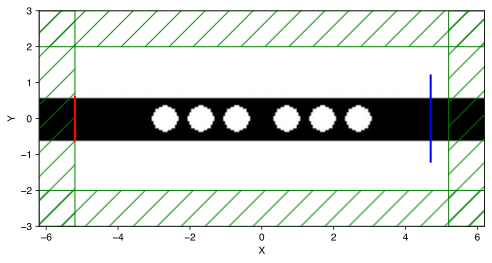

In [15]:
plt.figure(figsize=(8, 6))
sim.plot2D()
plt.show()

Now, we can run the simulation until the sources have finished plus some additional time to allow the fields to propagate through the structure. As in Tutorial/Basics, we'll use `stop_when_fields_decayed` to increment the time in steps of 50 time units (about 13 periods) until $|E_y|^2$ has decayed by at least 1/1000 at the transmission-flux plane.

We'll also animate the fields and generate a video.

In [16]:
f = plt.figure(dpi=150)
animate = mp.Animate2D(f=f, fields=mp.Hz, realtime=False, normalize=True)

sim.run(
    mp.during_sources(mp.at_every(0.4, animate)),
    until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3
    ),
)
plt.close()

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000550985 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (2.7,0,0)
          radius 0.3

In [17]:
filename = "media/hole-wvg-cavity.mp4"
animate.to_mp4(10, filename)
Video(filename)

Generating MP4...


We can see the pulse propagating to the right, bouncing off of the holes, and also exciting a resonant mode in the cavity that sits in the center for a long time as it starts slowly leaking to the right.

Of course, the main point of this section is to get the quantitative transmission spectrum. To do this, we need to normalize our flux by running the simulation with no holes. We'll first wrap the above code in a function so that we can parameterize the simulation domain.

In [18]:
def sim_cavity(N=3, sy=6):
    sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    cell = mp.Vector3(sx, sy, 0)
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
    geometry = [blk]

    for i in range(N):
        geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
        geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))

    src = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ey,
            center=mp.Vector3(-0.5 * sx + dpml),
            size=mp.Vector3(0, w),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        symmetries=sym,
        resolution=resolution,
    )

    freg = mp.FluxRegion(
        center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
    )
    nfreq = 500
    trans = sim.add_flux(fcen, df, nfreq, freg)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3
        )
    )

    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

Now we can compute the fluxes for both the simple waveguide and the cavity:

In [19]:
freqs_wg, psd_wg = sim_cavity(N=0)  # simple waveguide
freqs_cav, psd_cav = sim_cavity()  # cavity

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000883102 s
Working in 2D dimensions.
Computational cell is 6.4 x 6 x 0 with resolution 20
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
time for set_epsilon = 0.00564218 s
-----------
field decay(t = 50.025000000000006): 0.024304124551377645 / 0.024304124551377645 = 1.0
field decay(t = 100.05000000000001): 0.00029478773644368503 / 0.024304124551377645 = 0.01212912383741777
field decay(t = 150.07500000000002): 8.914669643908065e-14 / 0.024304124551377645 = 3.667965750036757e-12
run 0 finished at t = 150.07500000000002 (6003 timesteps)
-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000393152 s
Working in 2D dimensions.
Computational cell is 12.4 x 6 x 0 with resolution 20
     block, cent

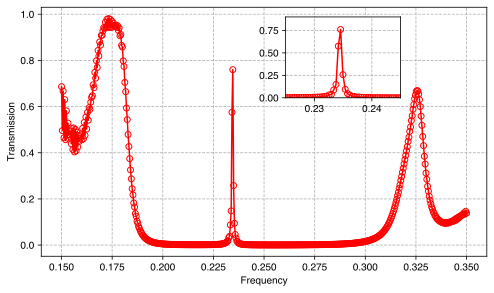

In [40]:
fig = plt.figure(figsize=(8, 4.5), dpi=100)
ax1 = fig.add_subplot(111)
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "ro-", markerfacecolor='none')
plt.grid(linestyle="--")
plt.xlabel("Frequency")
plt.ylabel("Transmission")

ax2 = fig.add_axes([0.55, 0.6, 0.2, 0.25])
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "ro-", markerfacecolor='none')
plt.xlim(0.225, 0.245)
plt.ylim(0, 0.9)
plt.grid(linestyle="--")